In [1]:
import sys
sys.path.insert(0, "/data/hpcdata/users/anddon76/icenet/icenet-experimental")
sys.path.insert(0, "/data/hpcdata/users/anddon76/icenet/icenet")
import os
os.chdir("/data/hpcdata/users/anddon76/icenet/icenet-experimental/")
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

In [89]:
forecast_unet = xr.open_dataarray("results/forecast_unet_single_year_ice_only_lag_two.nc")
forecast_unet

<xarray.DataArray (time: 30, leadtime: 1, yc: 432, xc: 432)>
[5598720 values with dtype=float32]
Coordinates:
  * time      (time) datetime64[ns] 2020-11-01 2020-11-02 ... 2020-11-30
  * leadtime  (leadtime) int64 1
  * yc        (yc) int64 0 1 2 3 4 5 6 7 8 ... 424 425 426 427 428 429 430 431
  * xc        (xc) int64 0 1 2 3 4 5 6 7 8 ... 424 425 426 427 428 429 430 431
Attributes:
    Description:  SIC forecast outputs from a UNet model, predicting SIC at t...

In [90]:
forecast_diffusion = xr.open_dataarray("results/forecast_diffusion_t1000_single_year_ice_only_lag_two.nc")
forecast_diffusion

<xarray.DataArray (member: 4, time: 30, leadtime: 1, yc: 432, xc: 432)>
[22394880 values with dtype=float32]
Coordinates:
  * member    (member) int64 0 1 2 3
  * time      (time) datetime64[ns] 2020-11-01 2020-11-02 ... 2020-11-30
  * leadtime  (leadtime) int64 1
  * yc        (yc) int64 0 1 2 3 4 5 6 7 8 ... 424 425 426 427 428 429 430 431
  * xc        (xc) int64 0 1 2 3 4 5 6 7 8 ... 424 425 426 427 428 429 430 431
Attributes:
    Description:  SIC forecast outputs from a diffusion model, predicting SIC...

In [91]:
truth = xr.open_dataarray("processed/single_year_ice_only_lag_two/osisaf/south/siconca/siconca_abs.nc")
truth = truth.sel(time=pd.date_range("2020-11-01", "2020-11-30"))
truth

<xarray.DataArray 'siconca_abs' (time: 30, yc: 432, xc: 432)>
[5598720 values with dtype=float64]
Coordinates:
  * xc       (xc) float64 -5.388e+06 -5.362e+06 ... 5.362e+06 5.388e+06
  * yc       (yc) float64 5.388e+06 5.362e+06 ... -5.362e+06 -5.388e+06
  * time     (time) datetime64[ns] 2020-11-01 2020-11-02 ... 2020-11-30
Attributes:
    long_name:            fully filtered concentration of sea ice using atmos...
    valid_max:            10000
    ancillary_variables:  total_standard_error status_flag
    standard_name:        sea_ice_area_fraction
    comment:              this field is the primary sea ice concentration est...
    units:                %
    grid_mapping:         Lambert_Azimuthal_Grid
    valid_min:            0
    coordinates:          lat lon

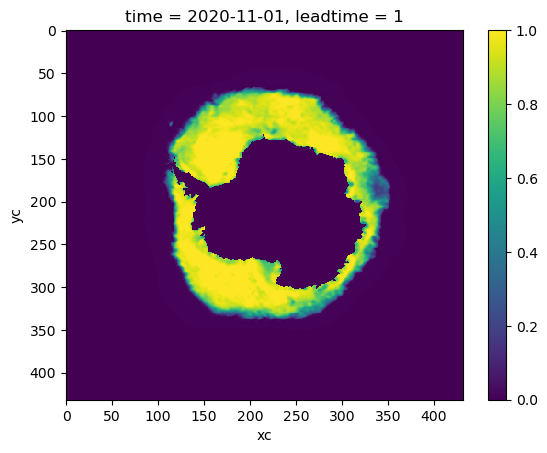

In [92]:
xr.plot.imshow(forecast_unet.isel(time=0, leadtime=0), origin="upper")

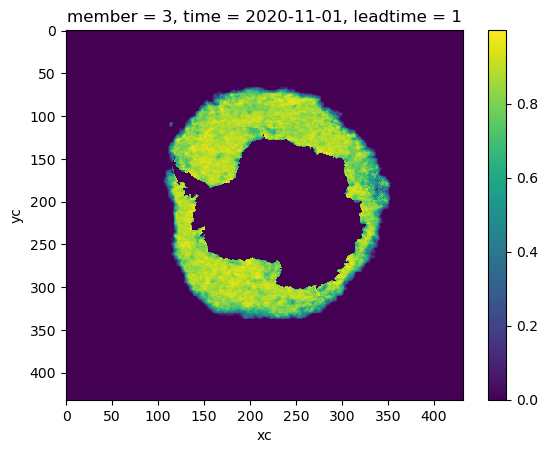

In [154]:
xr.plot.imshow(forecast_diffusion.isel(time=0, leadtime=0, member=3), origin="upper")

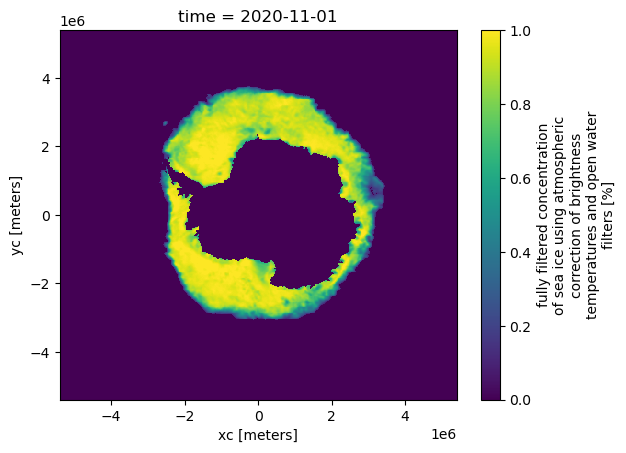

In [94]:
xr.plot.imshow(truth.isel(time=0))

## MSE

In [95]:
for member in range(4):
    mse = np.mean((forecast_diffusion.isel(member=member, leadtime=0).to_numpy() - truth.to_numpy())**2)
    print(mse)

0.002688695718584033
0.002576998490504764
0.0027949987434262038
0.0015910293086010788


In [96]:
mse = np.mean((forecast_unet.isel(leadtime=0).to_numpy() - truth.to_numpy())**2)
print(mse)

0.002003112556170235


## MAE

In [97]:
for member in range(4):
    mae = np.mean(np.abs(forecast_diffusion.isel(member=member, leadtime=0).to_numpy() - truth.to_numpy()))
    print(mae)

0.015110889484255069
0.014624725850546298
0.015623220714170107
0.012445872416934607


In [98]:
mae = np.mean(np.abs(forecast_unet.isel(leadtime=0).to_numpy() - truth.to_numpy()))
print(mae)

0.014324569607045505


## Ternary Accuracy
Where `0<SIC<0.15` is considered open water, `0.15<SIC<0.85` is considered marginal ice zone, and `0.85<SIC<1.0` is considered full ice.

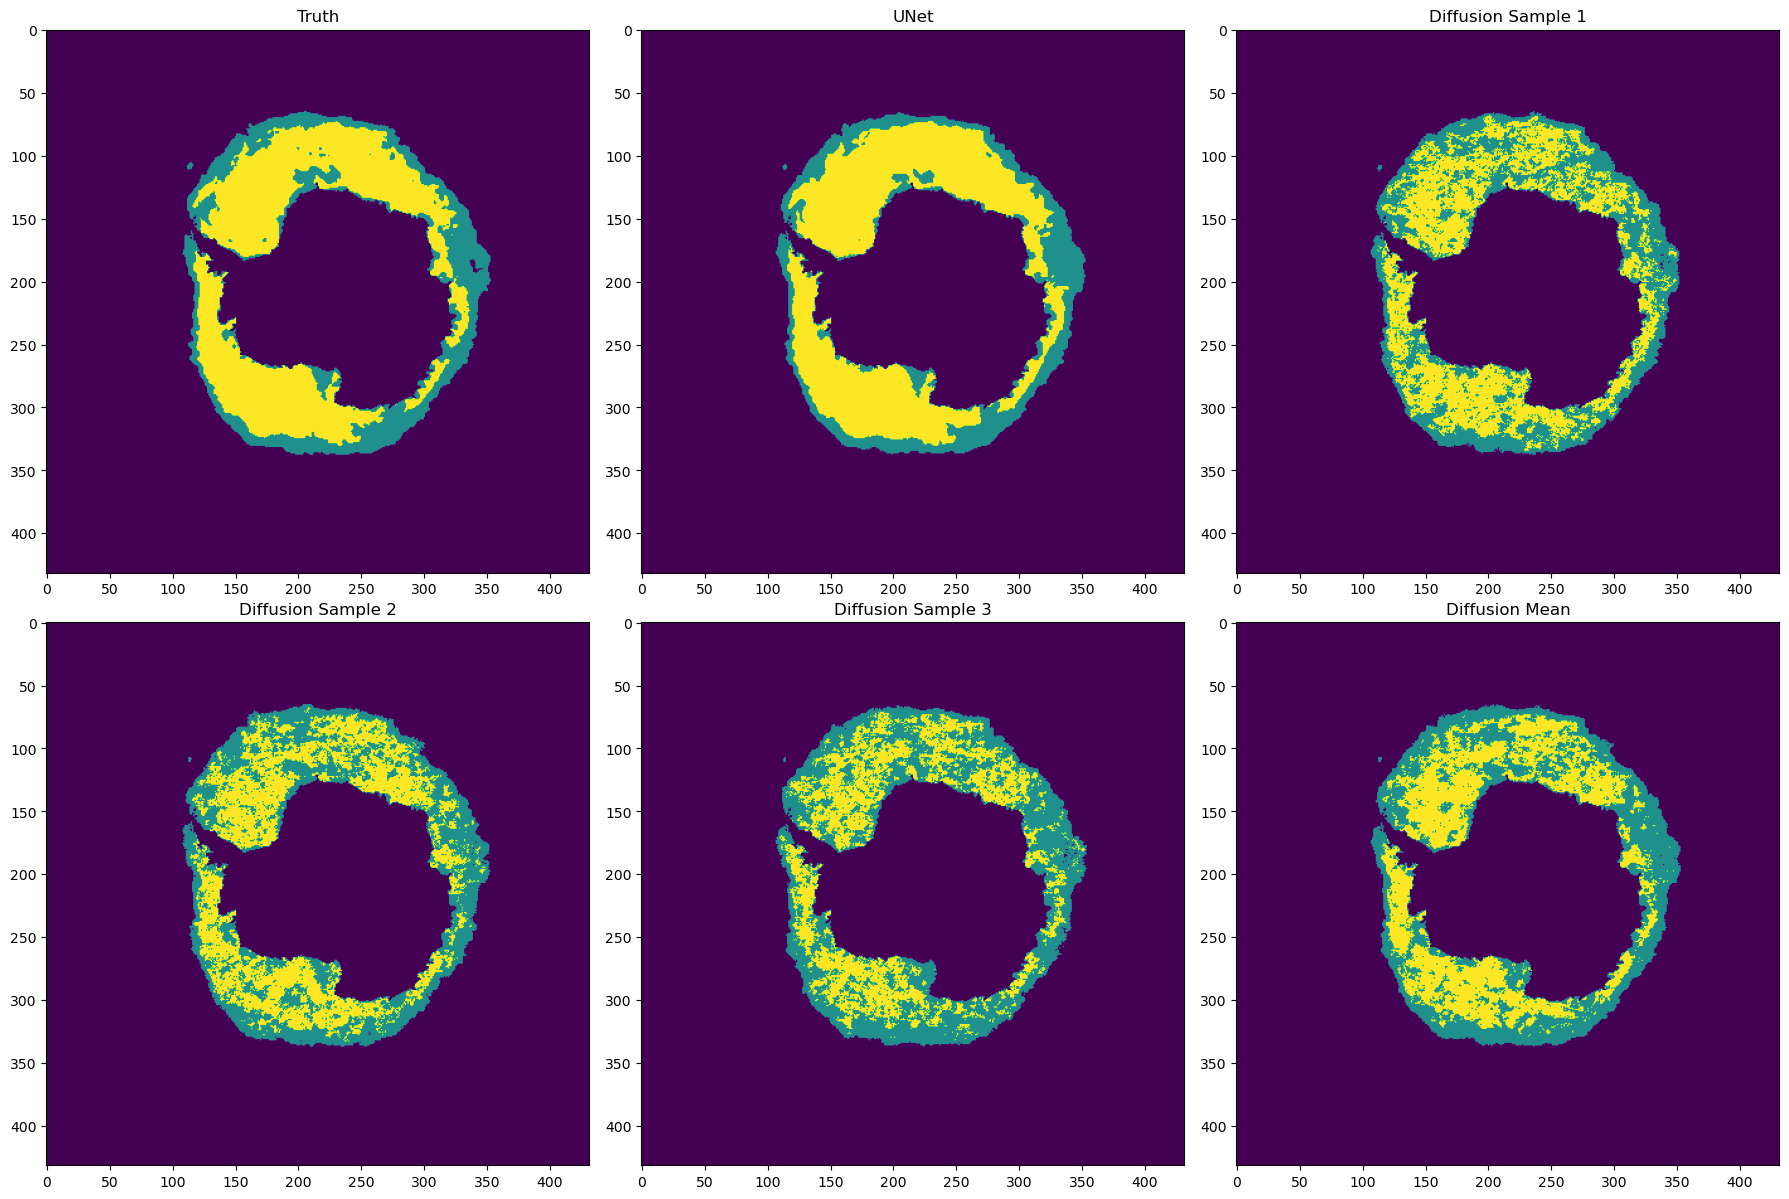

In [99]:
discrete_unet = np.where(forecast_unet.isel(leadtime=0).to_numpy() < 0.15, 0, 1)
discrete_unet = np.where(forecast_unet.isel(leadtime=0).to_numpy() > 0.85, 2, discrete_unet)
discrete_truth = np.where(truth.to_numpy() < 0.15, 0, 1)
discrete_truth = np.where(truth.to_numpy() > 0.85, 2, discrete_truth)
discretes_diffusion = []
for member in range(4):
    discrete_diffusion = np.where(forecast_diffusion.isel(member=member, leadtime=0).to_numpy() < 0.15, 0, 1)
    discrete_diffusion = np.where(forecast_diffusion.isel(member=member, leadtime=0).to_numpy() > 0.85, 2, discrete_diffusion)
    discretes_diffusion.append(discrete_diffusion)

fig, ax = plt.subplots(2, 3, figsize=(18, 12))
ax = ax.flatten()
discretes = [discrete_truth, discrete_unet]
discretes.extend(discretes_diffusion)
titles = ["Truth", "UNet", "Diffusion Sample 1", "Diffusion Sample 2", "Diffusion Sample 3", "Diffusion Mean"]
for i in range(6):
    ax[i].imshow(discretes[i][0])
    ax[i].set_title(titles[i])
plt.tight_layout()

In [100]:
np.mean(discrete_unet == discrete_truth)

0.9673162794352995

In [101]:
for member in range(4):
    print(np.mean(discretes_diffusion[member] == discrete_truth))

0.9541223708276177
0.9565949002629173
0.9524180526977595
0.9614317201074531


## Spectrum

In [102]:
# from https://github.com/robbiewatt1/ClimateDiffuse/blob/main/inference/compute_spectrum.py
import numpy as np
import scipy.stats as stats

def compute_spectrum2d(data):
    if data.ndim == 2:
        data = data[np.newaxis, ...]

    N, N_y, N_x = data.shape
    if N_x == 2 * N_y:
        data1 = data[:, :, :N_y]
        data2 = data[:, :, N_y:]
        data = np.concatenate((data1, data2), axis=0)
    N, N_y, N_x = data.shape

    # Take FFT and take amplitude
    fourier_image = np.fft.fftn(data, axes=(1,2))
    fourier_amplitudes = np.abs(fourier_image)**2

    # Get kx and ky
    kfreq_x = np.fft.fftfreq(N_x) * N_x
    kfreq_y = np.fft.fftfreq(N_y) * N_y

    # Combine into one wavenumber for both directions
    kfreq2D = np.meshgrid(kfreq_x, kfreq_y)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    knrm = np.repeat(knrm[np.newaxis, ...], repeats=N, axis=0)

    # Flatten arrays
    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()

    # Get k-bins and mean amplitude within each bin
    kbins = np.arange(0.5, N_x//2, 1)
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                         statistic="mean",
                                         bins=kbins)

    # Multiply by volume of bin
    Abins *= np.pi * (kbins[1:] ** 2 - kbins[:-1] ** 2)

    # Get center of k-bin for plotting
    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    return (kvals, Abins)

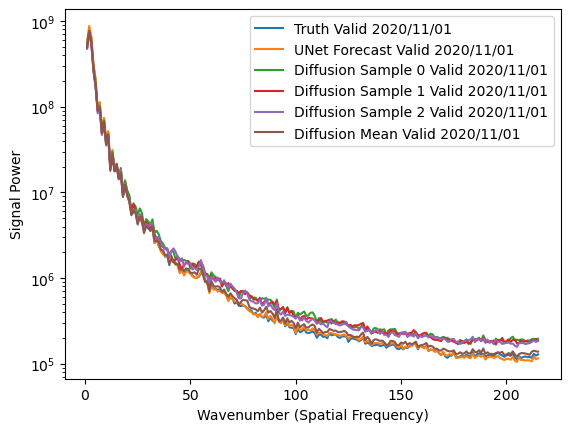

In [108]:
kvals, Abins = compute_spectrum2d(truth.isel(time=0).to_numpy())
plt.semilogy(kvals, Abins, label="Truth Valid 2020/11/01")
kvals, Abins = compute_spectrum2d(forecast_unet.isel(leadtime=0, time=0).to_numpy())
plt.semilogy(kvals, Abins, label="UNet Forecast Valid 2020/11/01")
for member in range(3):
    kvals, Abins = compute_spectrum2d(forecast_diffusion.isel(member=member, leadtime=0, time=0).to_numpy())
    plt.semilogy(kvals, Abins, label=f"Diffusion Sample {member} Valid 2020/11/01")    
kvals, Abins = compute_spectrum2d(forecast_diffusion.isel(member=3, leadtime=0, time=0).to_numpy())
plt.semilogy(kvals, Abins, label=f"Diffusion Mean Valid 2020/11/01")
plt.xlabel("Wavenumber (Spatial Frequency)")
plt.ylabel("Signal Power")
plt.legend()
plt.show()

In [151]:
np.datetime_as_string(truth.time[0].data, "D")

'2020-11-01'

In [153]:
from matplotlib.animation import FuncAnimation
fps = 3

def update(step):
    kvals, Abins = compute_spectrum2d(truth.isel(time=step).to_numpy())
    line1.set_ydata(Abins)
    kvals, Abins = compute_spectrum2d(forecast_unet.isel(leadtime=0, time=step).to_numpy())
    line2.set_ydata(Abins)
    for member in range(3):
        kvals, Abins = compute_spectrum2d(forecast_diffusion.isel(member=member, leadtime=0, time=step).to_numpy())
        line3[member].set_ydata(Abins)
    kvals, Abins = compute_spectrum2d(forecast_diffusion.isel(member=3, leadtime=0, time=step).to_numpy())
    line4.set_ydata(Abins)
    title = ax.set_title(f"Valid {np.datetime_as_string(truth.time[step].data, 'D')}")
    return line1, line2, line3, line4, title

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
kvals, Abins = compute_spectrum2d(truth.isel(time=0).to_numpy())
line1, = ax.semilogy(kvals, Abins, label=f"Truth", animated=True)
kvals, Abins = compute_spectrum2d(forecast_unet.isel(leadtime=0, time=0).to_numpy())
line2, = ax.semilogy(kvals, Abins, label=f"UNet", animated=True)
line3 = []
for member in range(3):
    kvals, Abins = compute_spectrum2d(forecast_diffusion.isel(member=member, leadtime=0, time=0).to_numpy())
    line, = ax.semilogy(kvals, Abins, label=f"Diffusion Sample {member}", animated=True)
    line3.append(line)
kvals, Abins = compute_spectrum2d(forecast_diffusion.isel(member=3, leadtime=0, time=0).to_numpy())
line4, = ax.semilogy(kvals, Abins, label=f"Diffusion Mean")
title = ax.set_title(f"Valid {np.datetime_as_string(truth.time[0].data, 'D')}")
plt.xlabel("Wavenumber (Spatial Frequency)")
plt.ylabel("Signal Power")
plt.legend()
plt.tight_layout()
animation = FuncAnimation(fig, update, range(30), interval=1000 / fps)
plt.close()
animation.save("/data/hpcdata/users/anddon76/icenet/icenet-experimental/results/spectrum.mp4", fps=fps)
# HTML(animation.to_jshtml())

## CRPS

## Skill/Spread

## SIE / SIA

## Rank Histogram

## Edge Computation

## Integrated Ice Edge Error